# ウナギ

この Notebook は、プログラミングの例題として実施しています。
この分析結果は、AI によって生成されたもので **不正確である可能性があります** 。

In [4]:
import logging
import cohere
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import requests
from io import BytesIO
import re

In [5]:
# 日本語フォントの設定（グラフ表示用）
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Hiragino Sans', 'Yu Gothic', 'Meiryo', 'MS Gothic']
plt.rcParams['axes.unicode_minus'] = False

# データの読み込み
data_url = "https://www.jfa.maff.go.jp/j/saibai/attach/xls/unagi-17.xlsx"
response = requests.get(data_url)
excel_data = BytesIO(response.content)

In [6]:
# Excelファイルの内容を確認
xls = pd.ExcelFile(excel_data)
print("シート名一覧:")
print(xls.sheet_names)
print("\n" + "="*50 + "\n")

# 各シートの内容をプレビュー
for sheet_name in xls.sheet_names:
    print(f"シート: {sheet_name}")
    df = pd.read_excel(xls, sheet_name=sheet_name)
    print(df.head())
    print(f"Shape: {df.shape}")
    print("\n" + "-"*50 + "\n")

シート名一覧:
['ウナギ稚魚採捕量']


シート: ウナギ稚魚採捕量
   シラスウナギ採捕量 Unnamed: 1 Unnamed: 2 Unnamed: 3
0        NaN        NaN      単位：トン        NaN
1     1957.0        S32        207        NaN
2        NaN        S33        207        NaN
3        NaN        S34        176        NaN
4        NaN        S35        122        NaN
Shape: (69, 4)

--------------------------------------------------



# データのクリーニングと整形

In [7]:
# データの読み込み
df = pd.read_excel(excel_data, sheet_name='ウナギ稚魚採捕量', header=None)
df.drop(index=df.index[[0,1]],
        columns=df.columns[[0, 3]], inplace=True)
df.reset_index(drop=True, inplace=True)
df.rename(columns={1: 'Japanese Era', 2: 'ammount'}, inplace=True)
df.head(5)

,Japanese Era,ammount
0,S32,207
1,S33,207
2,S34,176
3,S35,122
4,S36,196


In [8]:
JERA_SHIFT = {
    'S': 1925, # 昭和元年 1926
    'H': 1988, # 平成元年 1989
    'R': 2018, # 令和元年 2019
}

jera_pattern = re.compile(r'([A-Z])(元|\d+)')
def jera2year(text):
    m = jera_pattern.match(text)
    if m is None:
        logging.warning(text)
        return 0
    jera =  m.group(1)
    jyear = m.group(2)
    if jyear == '元':
        jyear = 1
    return int(JERA_SHIFT[jera] + int(jyear))

df['year'] = df['Japanese Era'].map(jera2year)

# year列とammount列を数値型に変換
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df['ammount'] = pd.to_numeric(df['ammount'], errors='coerce')

df.dropna(subset=['ammount'], inplace=True)

df.set_index('Japanese Era', inplace=True)

In [9]:
df

,ammount,year
Japanese Era,,
S32,207.0,1957
S33,207.0,1958
S34,176.0,1959
S35,122.0,1960
S36,196.0,1961
...,...,...
R2,17.1,2020
R3,11.3,2021
R4,10.3,2022


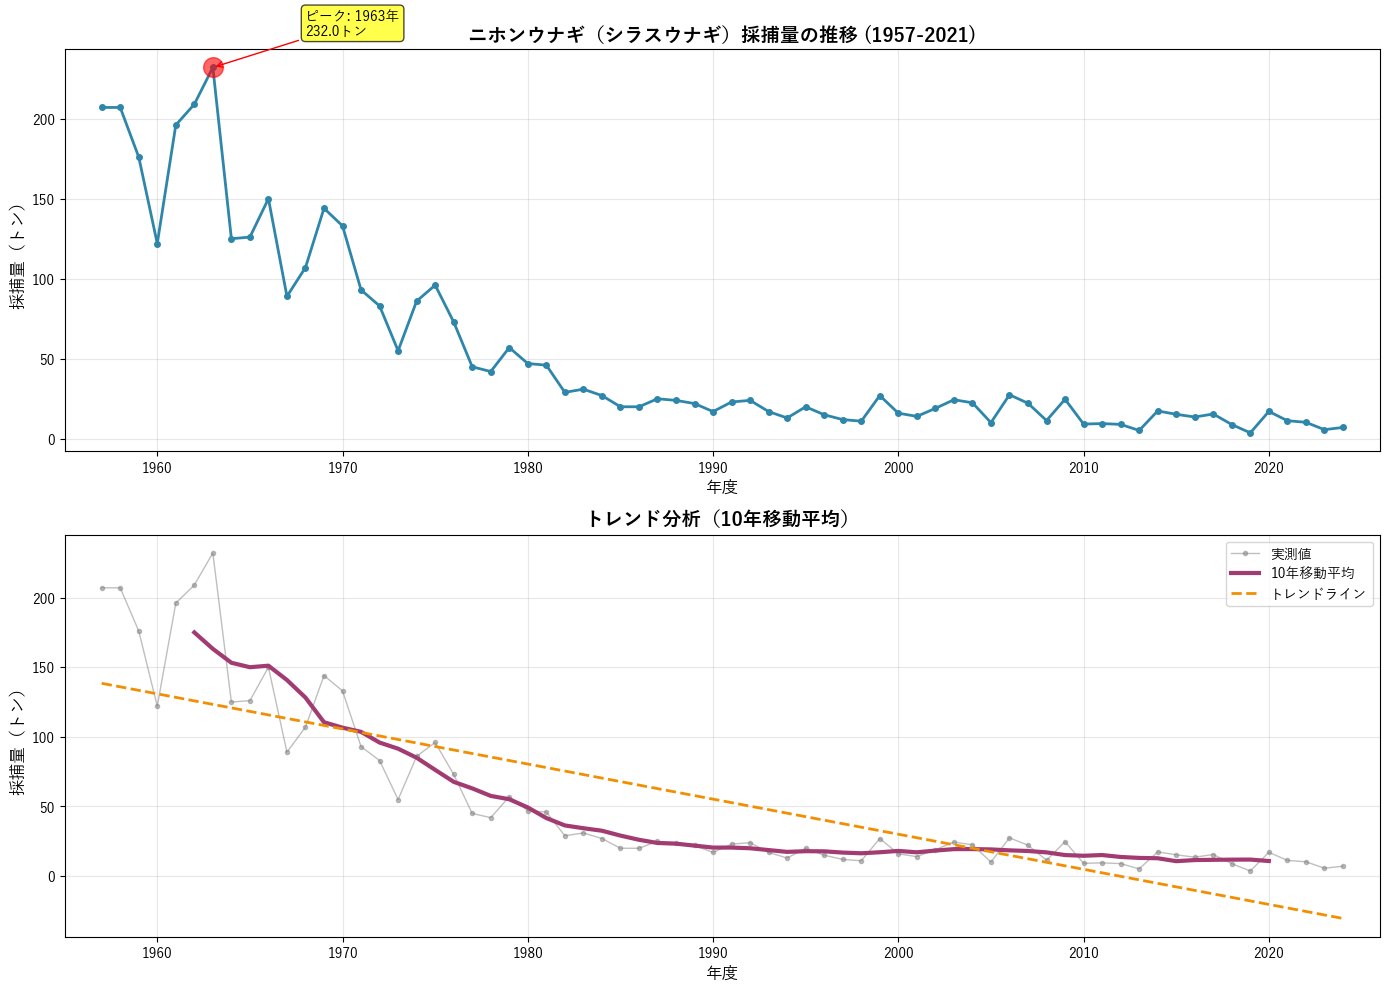


データサマリー
データ期間: 1957年 〜 2024年
ピーク: 1963年 (232.0トン)


TypeError: Cannot index by location index with a non-integer key

In [12]:
# 日本語フォントの設定（グラフ表示用）
plt.rcParams['font.sans-serif'] = ['YuGothic', 'Noto Sans JP', 'Noto Sans JP']
plt.rcParams['axes.unicode_minus'] = False

# 図のサイズを設定
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# ========================================
# グラフ1: 全期間の時系列推移
# ========================================
ax1 = axes[0]
ax1.plot(df['year'], df['ammount'], 
         marker='o', linewidth=2, markersize=4, color='#2E86AB')
ax1.set_xlabel('年度', fontsize=12)
ax1.set_ylabel('採捕量（トン）', fontsize=12)
ax1.set_title('ニホンウナギ（シラスウナギ）採捕量の推移 (1957-2021)', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(df['year'].min()-2, df['year'].max()+2)

# ピーク年をハイライト
peak_idx = df['ammount'].idxmax()
peak_year = df.loc[peak_idx, 'year']
peak_amount = df.loc[peak_idx, 'ammount']
ax1.scatter(peak_year, peak_amount, color='red', s=200, zorder=5, alpha=0.6)
ax1.annotate(f'ピーク: {peak_year}年\n{peak_amount}トン',
             xy=(peak_year, peak_amount),
             xytext=(peak_year+5, peak_amount+20),
             fontsize=10,
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
             arrowprops=dict(arrowstyle='->', color='red'))

# ========================================
# グラフ2: 10年移動平均とトレンド
# ========================================
ax2 = axes[1]

# 元データ
ax2.plot(df['year'], df['ammount'], 
         marker='o', linewidth=1, markersize=3, alpha=0.5, 
         color='gray', label='実測値')

# 10年移動平均
df['移動平均'] = df['ammount'].rolling(window=10, center=True).mean()
ax2.plot(df['year'], df['移動平均'], 
         linewidth=3, color='#A23B72', label='10年移動平均')

# トレンドライン（線形回帰）
z = np.polyfit(df['year'], df['ammount'], 1)
p = np.poly1d(z)
ax2.plot(df['year'], p(df['year']), 
         '--', linewidth=2, color='#F18F01', label='トレンドライン')

ax2.set_xlabel('年度', fontsize=12)
ax2.set_ylabel('採捕量（トン）', fontsize=12)
ax2.set_title('トレンド分析（10年移動平均）', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right', fontsize=10)
ax2.set_xlim(df['year'].min()-2, df['year'].max()+2)

plt.tight_layout()
plt.show()

min_idx = df['ammount'].idxmin()  # インデックス位置を取得
min_year = df.loc[min_idx, 'year']
min_amount = df.loc[min_idx, 'ammount']

# ========================================
# 基本統計の表示
# ========================================
print("\n" + "="*60)
print("データサマリー")
print("="*60)
print(f"データ期間: {df['year'].min()}年 〜 {df['year'].max()}年")
print(f"ピーク: {peak_year}年 ({peak_amount}トン)")
print(f"最小値: {df['year'].iloc[df['ammount'].idxmin()]}年 ({df['ammount'].min()}トン)")
print(f"平均採捕量: {df['ammount'].mean():.1f}トン")
print(f"直近10年平均: {df.tail(10)['ammount'].mean():.1f}トン")
print(f"減少率（ピークから直近）: {((df['ammount'].iloc[-1] - peak_amount) / peak_amount * 100):.1f}%")
print("="*60)

In [67]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 利用可能な日本語フォントを検索
japanese_fonts = [f.name for f in fm.fontManager.ttflist if 'JP' in f.name or 'Japanese' in f.name or 'Gothic' in f.name or 'Mincho' in f.name]
print("利用可能な日本語フォント:")
print(japanese_fonts[:10])  # 最初の10個を表示

利用可能な日本語フォント:
['Tsukushi B Round Gothic', 'YuGothic', 'Noto Sans JP', 'Noto Sans JP', 'BIZ UDMincho', 'Hiragino Mincho ProN', 'BIZ UDGothic', 'AppleGothic', 'YuGothic', 'Nanum Gothic']


# Cohere で分析

In [16]:
import cohere
import os
load_dotenv()
co = cohere.Client(os.environ['COHERE_APIKEY'])

# ========================================
# データをテキスト形式で準備
# ========================================
def prepare_data_summary(df):
    """データフレームを分析用のテキストに変換"""
    
    # 基本統計
    peak_idx = df['ammount'].idxmax()
    min_idx = df['ammount'].idxmin()
    
    summary = f"""
ニホンウナギ（シラスウナギ）採捕量データの概要：

【データ期間】{int(df['year'].min())}年 〜 {int(df['year'].max())}年（{len(df)}年分のデータ）

【主要統計】
- ピーク: {int(df.loc[peak_idx, 'year'])}年 ({df.loc[peak_idx, 'ammount']}トン)
- 最小値: {int(df.loc[min_idx, 'year'])}年 ({df.loc[min_idx, 'ammount']}トン)
- 平均採捕量: {df['ammount'].mean():.1f}トン
- 最近10年平均: {df.tail(10)['ammount'].mean():.1f}トン
- 減少率（ピークから最新）: {((df['ammount'].iloc[-1] - df.loc[peak_idx, 'ammount']) / df.loc[peak_idx, 'ammount'] * 100):.1f}%

【年代別データサンプル】
1950-1960年代: {df[df['year'] < 1970]['ammount'].mean():.1f}トン（平均）
1970-1980年代: {df[(df['year'] >= 1970) & (df['year'] < 1990)]['ammount'].mean():.1f}トン（平均）
1990-2000年代: {df[(df['year'] >= 1990) & (df['year'] < 2010)]['ammount'].mean():.1f}トン（平均）
2010-2020年代: {df[df['year'] >= 2010]['ammount'].mean():.1f}トン（平均）

【最近5年のデータ】
"""
    for _, row in df.tail(5).iterrows():
        summary += f"{int(row['year'])}年: {row['ammount']}トン\n"
    
    return summary

data_summary = prepare_data_summary(df)
print(data_summary)
print("\n" + "="*60 + "\n")

# ========================================
# Cohereによる分析実行
# ========================================
def analyze_with_cohere(data_text, analysis_type="general"):
    """Cohereを使ってデータ分析を実行"""
    
    prompts = {
        "general": f"""以下のニホンウナギ（シラスウナギ）採捕量データを分析してください。

{data_text}

以下の観点から分析を行ってください：
1. 長期的なトレンドの特徴
2. 顕著な変化が見られる時期とその背景要因
3. 現在の状況の深刻さ
4. データから読み取れる懸念点

専門的かつ分かりやすく説明してください。""",
        
        "causes": f"""以下のニホンウナギ採捕量データの減少要因について分析してください。

{data_text}

以下の観点から考察してください：
1. 生態学的要因（産卵場所、回遊ルート、気候変動など）
2. 人為的要因（乱獲、河川環境の変化、海洋汚染など）
3. 社会経済的要因（需要の変化、漁業規制など）

各要因の相対的な重要性も含めて説明してください。""",
        
        "forecast": f"""以下のニホンウナギ採捕量データに基づいて、今後の予測と提言を行ってください。

{data_text}

以下について考察してください：
1. 現在のトレンドが続いた場合の5年後、10年後の予測
2. 資源回復に必要な対策
3. 持続可能な管理のための提言

科学的根拠に基づいた実現可能な提案をお願いします。"""
    }
    
    prompt = prompts.get(analysis_type, prompts["general"])
    
    response = co.chat(
        message=prompt,
        model="command-a-03-2025",
        temperature=0.3,
        # stream=True  # ストリーミングを有効にする場合
    )
    
    return response.text

# ========================================
# 分析1: 総合的なトレンド分析
# ========================================
print("【分析1: 総合的なトレンド分析】")
print("="*60)
analysis_general = analyze_with_cohere(data_summary, "general")
print(analysis_general)
print("\n" + "="*60 + "\n")


ニホンウナギ（シラスウナギ）採捕量データの概要：

【データ期間】1957年 〜 2024年（68年分のデータ）

【主要統計】
- ピーク: 1963年 (232.0トン)
- 最小値: 2019年 (3.7トン)
- 平均採捕量: 54.0トン
- 最近10年平均: 10.8トン
- 減少率（ピークから最新）: -96.9%

【年代別データサンプル】
1950-1960年代: 160.8トン（平均）
1970-1980年代: 52.7トン（平均）
1990-2000年代: 18.5トン（平均）
2010-2020年代: 10.6トン（平均）

【最近5年のデータ】
2020年: 17.1トン
2021年: 11.3トン
2022年: 10.3トン
2023年: 5.7トン
2024年: 7.1トン



【分析1: 総合的なトレンド分析】
以下は、ニホンウナギ（シラスウナギ）採捕量データの分析結果です。専門的かつ分かりやすく説明します。

---

### **1. 長期的なトレンドの特徴**
ニホンウナギのシラスウナギ採捕量は、1957年から2024年にかけて**急激かつ一貫した減少傾向**を示しています。  
- **ピーク（1963年：232.0トン）**から**最新年（2024年：7.1トン）**までの減少率は**-96.9%**に達し、ほぼ絶滅に近いレベルまで減少しています。  
- 年代別の平均採捕量を見ると、**1950-1960年代**の160.8トンをピークに、**1970-1980年代**で52.7トン、**1990-2000年代**で18.5トン、**2010-2020年代**で10.6トンと、**約10年ごとに半減**するペースで減少しています。  
- 最近10年の平均採捕量（10.8トン）は、ピーク時のわずか**4.7%**であり、長期的な減少トレンドが明確です。

---

### **2. 顕著な変化が見られる時期とその背景要因**
#### **（1）1970年代以降の急激な減少**  
- **背景要因**:  
  - 過剰漁獲：シラスウナギの需要が高まる中、乱獲が進行。  
  - 生息環境の悪化：河川のダム建設や水質汚染により、ウナギの産卵・生育環境が劣化。  
  - 海洋環境の変化：海洋循環や気候変動の影響で、ウ

# RAG で補正

In [17]:
# ========================================
# 知識ベースの準備
# ========================================
# ニホンウナギに関する外部知識 ※修正予定
knowledge_base = [
    {
        "title": "ニホンウナギの生態",
        "content": "ニホンウナギ（Anguilla japonica）は、マリアナ諸島西方海域で産卵し、シラスウナギとして日本、中国、台湾、韓国などの河川に遡上する。産卵場所の特定は2006年に塚本勝巳博士らによって行われた。回遊距離は約3000kmに及ぶ。"
    },
    {
        "title": "絶滅危惧種指定",
        "content": "2014年6月、国際自然保護連合（IUCN）のレッドリストで絶滅危惧IB類に指定された。日本国内でも2013年に環境省レッドリストで絶滅危惧IB類に指定されている。主な減少要因は乱獲、生息地の減少、海洋環境の変化などが挙げられる。"
    },
    {
        "title": "漁業規制の動向",
        "content": "2014年から池入れ数量の上限設定が開始された。養鰻業者による池入れ制限は、日本、中国、台湾、韓国の4カ国・地域で合意された。日本の池入れ上限は約21.7トンに設定されている。しかし、違法漁獲や密輸の問題も指摘されている。"
    },
    {
        "title": "気候変動の影響",
        "content": "黒潮の流路変動や海水温の上昇がシラスウナギの輸送効率に影響を与えている可能性が指摘されている。エルニーニョ現象との関連性も研究されており、海洋環境の変化が漁獲量の変動に大きく影響していると考えられる。"
    },
    {
        "title": "河川環境の変化",
        "content": "河川の護岸工事、ダム建設、水質汚染などにより、ウナギの生息環境が悪化している。特に、河口域の改変や中流域の連続性の分断が、ウナギの生活史に悪影響を及ぼしている。"
    },
    {
        "title": "完全養殖の研究",
        "content": "2010年に水産総合研究センターが世界で初めてニホンウナギの完全養殖に成功。しかし、コストや生存率の問題から商業化には至っていない。完全養殖の実用化には、まだ技術的・経済的課題が多く残されている。"
    },
    {
        "title": "歴史的な漁獲量の変遷",
        "content": "1960年代には年間200トン前後の豊漁が続いていたが、1970年代後半から減少傾向が顕著になった。特に2000年代以降は急激な減少が続き、2013年には過去最低の5.2トンを記録した。"
    },
    {
        "title": "国際的な取引規制",
        "content": "ワシントン条約（CITES）での規制対象化が議論されているが、まだ附属書への掲載には至っていない。東アジア各国での消費需要が高く、規制強化には国際協調が不可欠である。"
    }
]

# ========================================
# テキストの埋め込み生成
# ========================================
def create_embeddings(texts):
    """テキストリストの埋め込みを生成"""
    response = co.embed(
        texts=texts,
        model="embed-multilingual-v3.0",  # 多言語対応モデル
        input_type="search_document"
    )
    return response.embeddings

# 知識ベースの埋め込みを生成
knowledge_texts = [f"{doc['title']}: {doc['content']}" for doc in knowledge_base]
knowledge_embeddings = create_embeddings(knowledge_texts)

print("知識ベースの埋め込みを生成しました")
print(f"ドキュメント数: {len(knowledge_embeddings)}")
print(f"埋め込みの次元数: {len(knowledge_embeddings[0])}")
print("\n" + "="*60 + "\n")

# ========================================
# 類似度検索とRerank
# ========================================
def retrieve_relevant_docs(query, top_k=3):
    """クエリに関連するドキュメントを検索"""
    
    # クエリの埋め込みを生成
    query_embedding = co.embed(
        texts=[query],
        model="embed-multilingual-v3.0",
        input_type="search_query"
    ).embeddings[0]
    
    # コサイン類似度を計算
    similarities = []
    for i, doc_embedding in enumerate(knowledge_embeddings):
        similarity = np.dot(query_embedding, doc_embedding) / (
            np.linalg.norm(query_embedding) * np.linalg.norm(doc_embedding)
        )
        similarities.append((i, similarity))
    
    # 類似度順にソート
    similarities.sort(key=lambda x: x[1], reverse=True)
    initial_results = similarities[:top_k*2]  # Rerankのために多めに取得
    
    # Rerankで精度向上
    rerank_docs = [knowledge_texts[i] for i, _ in initial_results]
    rerank_response = co.rerank(
        query=query,
        documents=rerank_docs,
        model="rerank-multilingual-v3.0",
        top_n=top_k
    )
    
    # Rerank結果から関連ドキュメントを取得
    relevant_docs = []
    for result in rerank_response.results:
        original_idx = initial_results[result.index][0]
        relevant_docs.append({
            "content": knowledge_base[original_idx],
            "relevance_score": result.relevance_score
        })
    
    return relevant_docs

# ========================================
# RAG分析の実行
# ========================================
def rag_analysis(data_summary, analysis_query):
    """RAGを使用した分析"""
    
    print(f"クエリ: {analysis_query}")
    print("-" * 60)
    
    # 関連ドキュメントを取得
    relevant_docs = retrieve_relevant_docs(analysis_query, top_k=3)
    
    print("【取得された関連知識】")
    for i, doc in enumerate(relevant_docs, 1):
        print(f"\n{i}. {doc['content']['title']} (関連度: {doc['relevance_score']:.3f})")
        print(f"   {doc['content']['content']}")
    
    print("\n" + "="*60 + "\n")
    
    # RAGプロンプトの構築
    context = "\n\n".join([
        f"【参考情報{i}】{doc['content']['title']}\n{doc['content']['content']}"
        for i, doc in enumerate(relevant_docs, 1)
    ])
    
    prompt = f"""以下の参考情報とデータを基に、ニホンウナギの漁獲量について分析してください。

{context}

【漁獲量データ】
{data_summary}

【分析テーマ】
{analysis_query}

参考情報を活用しながら、データのトレンドを科学的・客観的に分析してください。
具体的な数値や時期を示しながら説明してください。"""
    
    # Cohereで回答生成
    response = co.chat(
        message=prompt,
        model="command-a-03-2025",
        temperature=0.3,
    )
    
    print("【RAG分析結果】")
    print(response.text)
    print("\n" + "="*60 + "\n")
    
    return response.text

# ========================================
# 分析クエリの実行
# ========================================

# 分析1: 減少トレンドの要因分析
print("\n【RAG分析1: 漁獲量減少の要因】\n")
query1 = "1960年代から現在までのニホンウナギ漁獲量の減少トレンドについて、その主要な要因を分析してください"
result1 = rag_analysis(data_summary, query1)

# 分析2: 2000年代以降の急激な減少
print("\n【RAG分析2: 2000年代以降の急激な減少】\n")
query2 = "2000年代以降の漁獲量の急激な減少について、生態学的・社会的背景を含めて説明してください"
result2 = rag_analysis(data_summary, query2)

# 分析3: 今後の見通しと対策
print("\n【RAG分析3: 今後の見通しと保護対策】\n")
query3 = "現在のデータトレンドと保護策の効果を踏まえて、今後の見通しと必要な対策を提言してください"
result3 = rag_analysis(data_summary, query3)

知識ベースの埋め込みを生成しました
ドキュメント数: 8
埋め込みの次元数: 1024



【RAG分析1: 漁獲量減少の要因】

クエリ: 1960年代から現在までのニホンウナギ漁獲量の減少トレンドについて、その主要な要因を分析してください
------------------------------------------------------------
【取得された関連知識】

1. 歴史的な漁獲量の変遷 (関連度: 0.295)
   1960年代には年間200トン前後の豊漁が続いていたが、1970年代後半から減少傾向が顕著になった。特に2000年代以降は急激な減少が続き、2013年には過去最低の5.2トンを記録した。

2. 気候変動の影響 (関連度: 0.010)
   黒潮の流路変動や海水温の上昇がシラスウナギの輸送効率に影響を与えている可能性が指摘されている。エルニーニョ現象との関連性も研究されており、海洋環境の変化が漁獲量の変動に大きく影響していると考えられる。

3. 河川環境の変化 (関連度: 0.008)
   河川の護岸工事、ダム建設、水質汚染などにより、ウナギの生息環境が悪化している。特に、河口域の改変や中流域の連続性の分断が、ウナギの生活史に悪影響を及ぼしている。


【RAG分析結果】
ニホンウナギの漁獲量は、1960年代をピークに減少傾向が続き、特に2000年代以降は急激な減少を示しています。以下、参考情報とデータを基に、主要な減少要因を分析します。

### 1. **歴史的な漁獲量のトレンド**
- **ピーク期（1960年代）**: 1963年に232.0トンのピークを記録し、平均採捕量は160.8トンと豊漁が続いていました。  
- **減少期（1970年代以降）**: 1970年代後半から減少傾向が顕著になり、1970-1980年代の平均採捕量は52.7トンに低下しました。  
- **急激な減少期（2000年代以降）**: 2000年代以降はさらに減少が加速し、2013年には5.2トン、2019年には過去最低の3.7トンを記録しました。  
- **最新状況**: 最近10年の平均採捕量は10.8トンで、ピーク時から**96.9%減少**しています。

### 2. **主要な減少要因の分析**
#### **(1

※この分析結果は、 **AI によって生成されたもので 不正確である可能性があります** ※